# Abgabe 4: Statistische Mechanik

**Teammitglieder:** René Zarwel, Matthias Kastenmüller

<br>

Importieren allgemein benötigter Bibliotheken:

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import *
import pylab as pylab
import numpy.polynomial.polynomial as poly
import numpy as np
from numpy import *
from numpy.linalg import norm
import numpy.random as rn
from scipy.integrate import odeint
import copy
import math
import random
#import vpython as vp         # get VPython modules for animation
#vec=vp.vector

## Aufgabe 1: Scheiben in einem Quadrat

### a) Simulation mittels Molekulardynamik

In [6]:
def compute_energy(x, v):
    Vkin = 0
    for i in range(len(x)):
        Vkin += 0.5*dot(v[i,:],v[i,:])
    return Vkin

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

def run(pos, vel, sigma, n_events):
    xHist = []
    vHist = [] 
    singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
    pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    t = 0.0
    for event in range(n_events):
        xHist.append(copy.deepcopy(pos))
        vHist.append(copy.deepcopy(vel))
        wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
        pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
        next_event = min(wall_times + pair_times)
        t += next_event
        for k, l in singles: pos[k][l] += vel[k][l] * next_event
        if min(wall_times) < min(pair_times):
            collision_disk, direction = singles[wall_times.index(next_event)]
            vel[collision_disk][direction] *= -1.0
        else:
            a, b = pairs[pair_times.index(next_event)]
            del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
            abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
            e_perp = [c / abs_x for c in del_x]
            del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
            scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
            for k in range(2):
                vel[a][k] += e_perp[k] * scal
                vel[b][k] -= e_perp[k] * scal
    VKinHist = []
    xHist = array(xHist)
    vHist = array(vHist)
    for i,ti in enumerate(xHist):
        Vkin = compute_energy(xHist[i,:,:], vHist[i,:,:])
        VKinHist.append(Vkin)
    return xHist, vHist, array(VKinHist)

def plotMD(xhist, vhist, vkinHist):
    # Plot der Daten
    figure(figsize=(15,15))
    subplot(221)
    c = []
    for i in range(xhist.shape[1]):
        c.append(cm.rainbow((float(i)/xhist.shape[1])))
        plot(xhist[0,i,0], xhist[0,i,1],'o', color=c[i])
        plot(xhist[-1,i,0], xhist[-1,i,1],'s', color=c[i])
        plot(xhist[:,i,0], xhist[:,i,1], color=c[i])
    axis('equal')
    title('Trajektorien')
    xlabel('$x$')
    ylabel('$y$')
    grid(True)
    legend( [Line2D([],[], linestyle='-', color='k'),
             Line2D([],[], linestyle='', marker='o', color='k'),
             Line2D([],[], linestyle='', marker='s', color='k')],
            ["Verlauf",
             "$x(t=0)$",
             r'$x(t=t_{end})$'],
            numpoints=1)

    subplot(222)
    hist(xhist[:,:,0], color=c)
    title('Histogram')
    xlabel('$x$')
    ylabel('Anzahl')  
    
    subplot(223)
    axes = plt.gca()
    axes.set_xlim([0,len(vkinHist)])
    axes.set_ylim([0,2*max(vkinHist)])
    plot(range(len(vkinHist)), vkinHist, label='Kinetisch')
    grid(True)
    xlabel('Event')
    ylabel('Energie')
    title('Energie pro Event')
    legend()

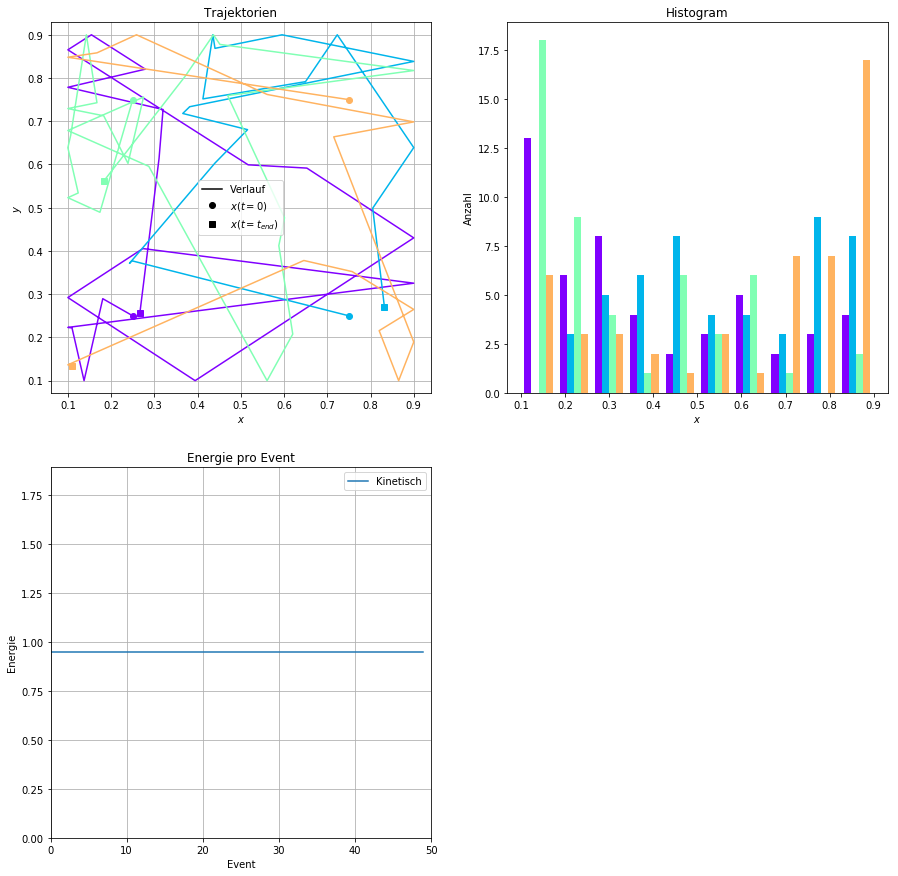

In [7]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.1
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

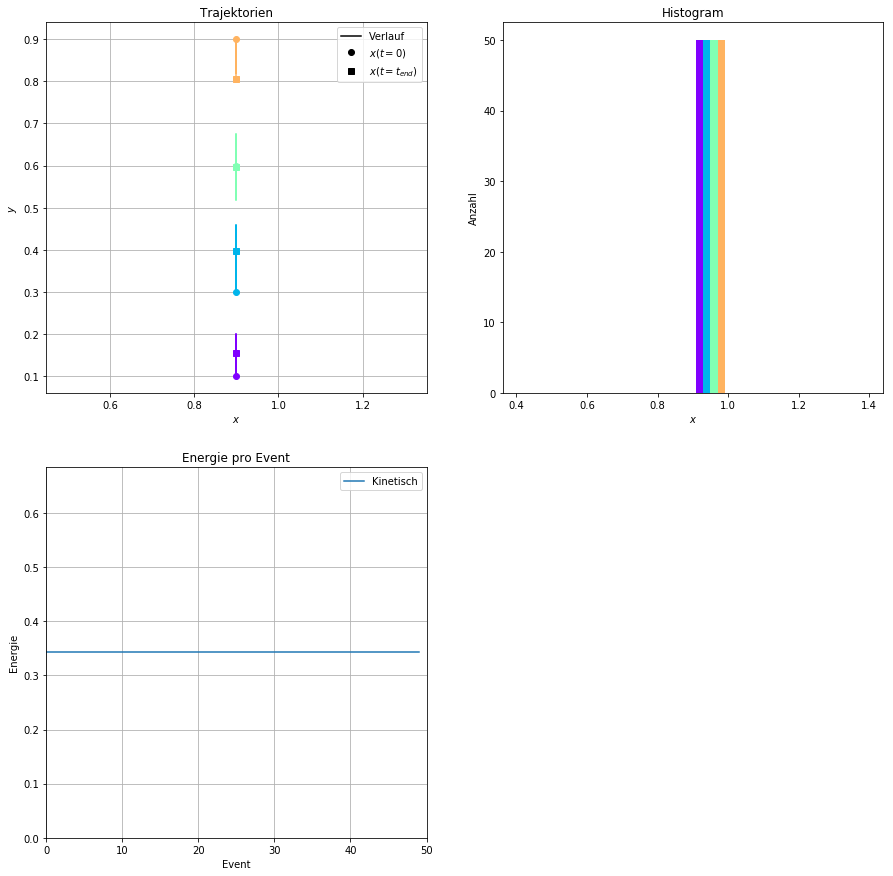

In [23]:
pos = [[0.9, 0.1], [0.9, 0.3], [0.9, 0.6], [0.9, 0.9]]
vel = [[0, 0.12], [0, 0.18], [0, -0.79], [0, 0.1177]]
sigma = 0.1
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

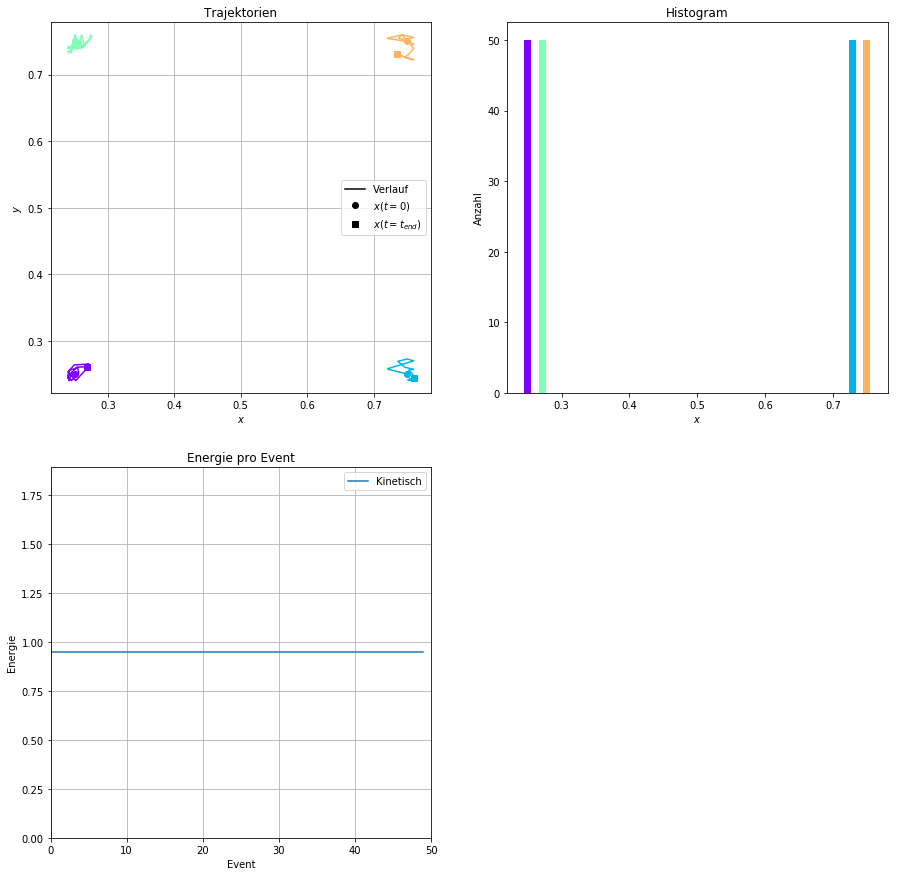

In [24]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.24
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

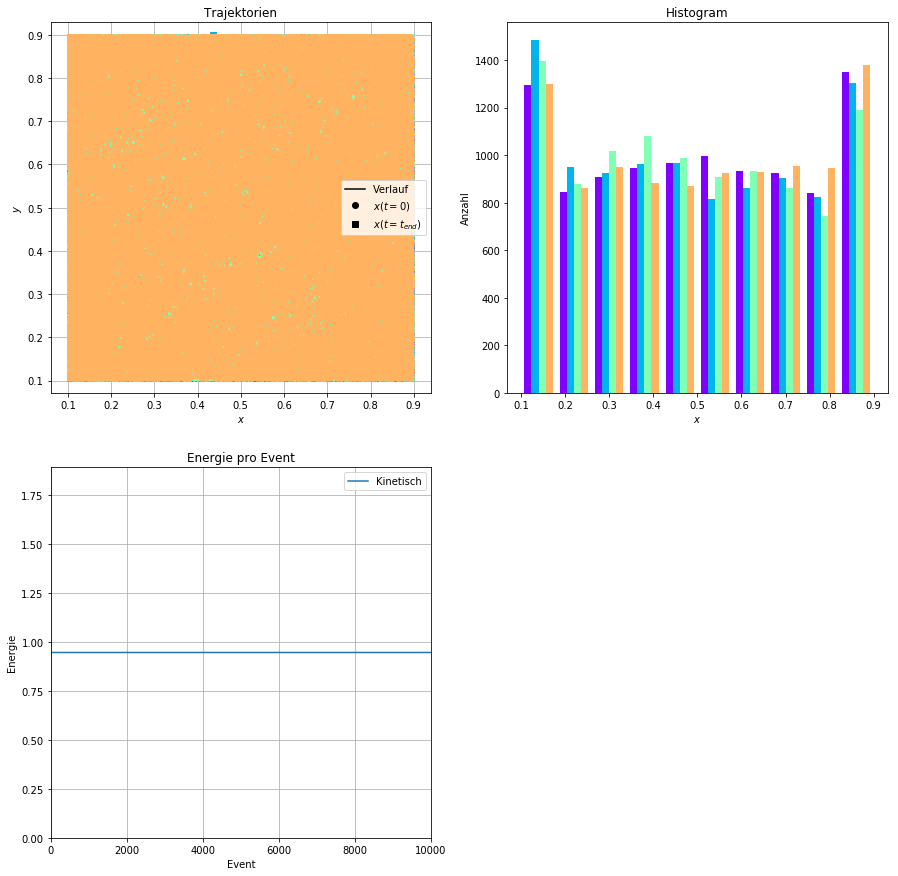

In [50]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.1
n_events = 10000
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

### b) Simulation mittels Markov-Monte-Carlo-Algorithmus

Text(0,0.5,'Anzahl')

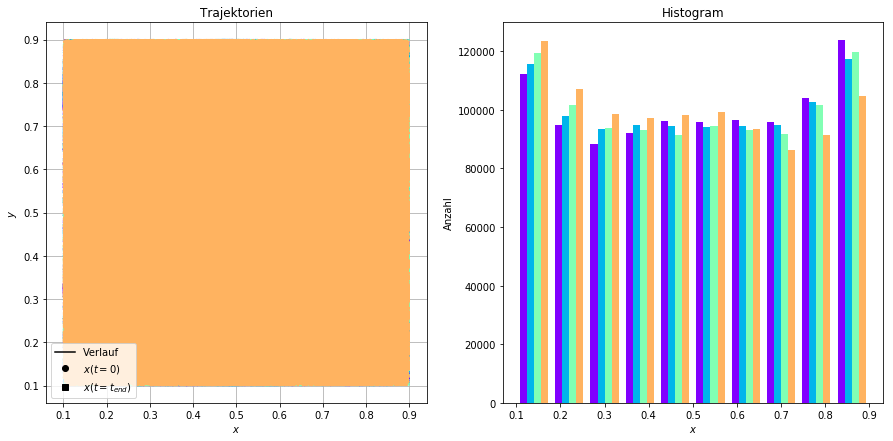

In [53]:
L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
sigma = 0.1
sigma_sq = sigma ** 2
delta = 0.1
n_steps = 1000000
xhist = []
for steps in range(n_steps):
    a = random.choice(L)
    b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
    min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a)
    box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
    if not (box_cond or min_dist < 4.0 * sigma ** 2):
        a[:] = b
    xhist.append(copy.deepcopy(L))

xhist = array(xhist)
# Plot der Daten
figure(figsize=(15,7))
subplot(121)
c = []
for i in range(xhist.shape[1]):
    c.append(cm.rainbow((float(i)/xhist.shape[1])))
    plot(xhist[0,i,0], xhist[0,i,1],'o', color=c[i])
    plot(xhist[-1,i,0], xhist[-1,i,1],'s', color=c[i])
    plot(xhist[:,i,0], xhist[:,i,1], color=c[i])
axis('equal')
title('Trajektorien')
xlabel('$x$')
ylabel('$y$')
grid(True)
legend( [Line2D([],[], linestyle='-', color='k'),
         Line2D([],[], linestyle='', marker='o', color='k'),
         Line2D([],[], linestyle='', marker='s', color='k')],
        ["Verlauf",
         "$x(t=0)$",
         r'$x(t=t_{end})$'],
        numpoints=1)

subplot(122)
hist(xhist[:,:,0], color=c)
title('Histogram')
xlabel('$x$')
ylabel('Anzahl') 

## Aufgabe 2: Monte-Carlo-Verfahren zur Integration

Es sollen Zufallszahlen generiert werden, die einer bestimmten Verteilung entsprechen. Python bzw. numpy enthällt keinen Generator der für eine bestimmte Verteilung die anhand einer Funktion gegeben ist zufällige Werte generiert. Daher müssen zunächst gleichverteilte Zufallszahlen generiert werden, die anschließend durch eine passende Funktion so angepasst werden, dass die Zufallszahlen der gewünschten Verteilung entsprechen.

Eine solche Funktion muss die Eigenschaft haben, dass sie eine geringe Steigung an den Stellen aufweist bei denen die Zielverteilung eine hohe Dichte aufweist. Dadurch werden ein großer Bereich der gleichverteilten Zufallspunkte auf einen verhälltnismäßig kleinen Bereich abgebildet.

Daraus folgt: Es ist die Fläche der rezibroken Verteilungsfunktion (im folgenden fr genannt).
Herangehensweise für die erste Verteilung:
\begin{align}
p(x)=e^{-x}\\
fr(x)=\int\!\frac{a}{e^{-x}} \, \mathrm{d}x=\int\!a e^{x} \, \mathrm{d}x
\end{align}
Der Faktor a ist zunächst unbekannt, sodass dieser bei der Integration nicht in Betracht gezogen werden muss. Man erhällt:
\begin{align}
fr(x)=\left[a e^x\right]\\
fr(x)=a e^x +b
\end{align}
Zunächst sind a und b unbekannt. Sie müssen so gewählt werden, dass sie den Wertebereich der gleichverteilten Quelle genau auf den gewünschten Zielbereich abbilden. Es wird festgelegt, dass der Quellbereich identisch zum Zielbereich 0-2 ist. Daduch lassen sich zwei Gleichungen bilden:
\begin{align}
fr(x)=a e^x +b\\
0=a e^0 +b\\
2=a e^2 +b\\
a=\frac{2}{-e^2+1}\approx+0.3130 \\
b=\frac{-2}{-e^2+1}\approx-0.3130
\end{align}
Zusammengefasst:
\begin{align}
fr(x)=\frac{2}{-e^2+1} e^x + \frac{-2}{-e^2+1}\approx0.3130 e^x -0.3130
\end{align}

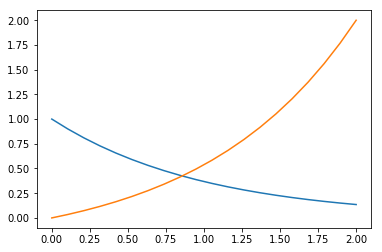

In [25]:
f1 = lambda x: math.e**-x
fr = lambda x: 0.3130*math.e**x-0.3130


plt.plot(np.linspace(0,2,20),f1(np.linspace(0,2,20)))
plt.plot(np.linspace(0,2,20),fr(np.linspace(0,2,20)))

Wie zu erkennen ist, erfüllt die Funktion fr die o.g. theoretischen Anforderungen.
Werden nun Zufallszahlen mit dieser Funktion entsprechend umgeformt, so spiegelt sich die gewünschte Verteilung im Hinstogramm wieder.

(array([215., 164., 134., 114.,  85.,  76.,  67.,  54.,  47.,  44.]),
 array([3.33932664e-04, 1.99310860e-01, 3.98287787e-01, 5.97264714e-01,
        7.96241641e-01, 9.95218568e-01, 1.19419549e+00, 1.39317242e+00,
        1.59214935e+00, 1.79112628e+00, 1.99010320e+00]),
 <a list of 10 Patch objects>)

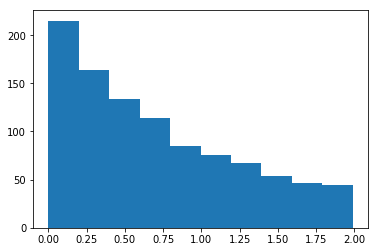

In [26]:
randVals = np.random.uniform(0, 2, 1000)
plt.hist(fr(randVals))

Es war eine weitere Verteilung gegeben. Die oben beschriebene Vorgehensweise wird dafür wiederhohlt. Aufgrund der Komplexität des Integrals wird hier numerisch vorgegangen.
Dazu wird die Fläche unter der Funktion in n Streifen unterteilt. Da hier das Intervall von 0 bis 2 angesetzt wird, hat jeder Streifen dementsprechend die Breite (x -10) / n. 

Die Fläche (F2u) erhällt man nun durch aufsummieren aller Teilflächen (Streifen):

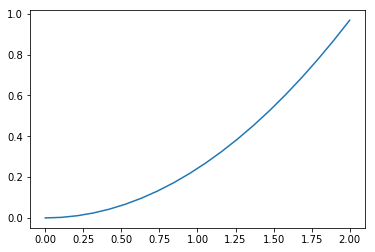

In [28]:
n = 50

f2 = lambda x: 1/(math.sqrt(2*math.pi)) * math.e**-0.5*x**2
F2u = lambda x: 1 / (np.sum(f2(np.linspace(0, x, n))* ((x) / n)))

plt.plot(np.linspace(0,2,20),f2(np.linspace(0,2,20)))

Auch hier müssen die Grenzen mit in die Berechnung einfließen:
\begin{align}
fr2(x)=a*F2u+b
\end{align}
Da für die ursprüngliche Funktion f(0)=0 gilt, würde man beim Bilden der rezibroken Funktion an dieser Stelle durch 0 teilen. Daher wird die Untergrenze 0 ausgeschlossen. Numerisch drückt sich dieser Vorgang durch einen Wert nahe 0 aus.
Durch Einsetzen der Ober- und Untergrenze in F2u erhällt man wieder zwei Gleichungen:

In [29]:
print(F2u(0.001))
print(F2u(2))
print(2/F2u(2))

12272959778.909224
1.5341199723636525
1.3036790055725276


\begin{align}
0=a\cdot0+b\\
2=a*0.652+b
\end{align}
Dementsprechend ist:
\begin{align}
b=0\\
a\approx3.068
\end{align}

/home/matthias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


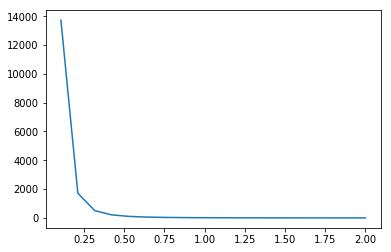

In [31]:
fr2 = lambda x: 2/F2u(2) * F2u(x)
plt.plot(np.linspace(0,2,20),[fr2(x) for x in np.linspace(0,2,20)])

Aufgabenteil b)

Mit Hilfe des Monte-Carlo-Verfahrens soll nun das Volumen einer 10-D Kugel berechnet werden.

Dazu muss zunächst eine Strategie gefunden werden, die erkennt ob ein gegebener Punkt innerhalb oder außerhalb der Kugel liegt. Dazu kann folgende Formel verwendet werden:
\begin{align}
\vec{p}= \left( \begin{array}{c}x_1\\x_1\\...\\x_n\end{array} \right) \\
\sum\nolimits_{d=1}^Nx_d  \leq r
\end{align}
Gilt die Ungleichung, so liegt der Punkt innerhalb der Kugel. Da dieser Ansatz sehr häufig verwendet wird, wird dieser in eine Funktion ausgelagert.

In [32]:
from mpl_toolkits.mplot3d import axes3d

def inHyperkugel(v, r):
    sum = 0
    for i in v:
        sum = sum + i ** 2
    return sum <= r

Um den Ansatz nun zu validieren, wird zunächst die Fläche eines Kreises errechnet. Dazu werden n gleichverteilte Zufallszahlen generiert. Für jede wird geprüft ob sie innerhalb des Kreises liegt. Alle Treffer werden gezählt.

Von 1000 wurden 774 erkannt.


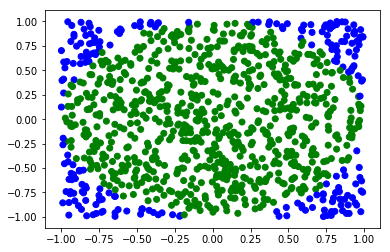

In [33]:
n = 1000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 1, n)

color = []
treffer = 0
for i in range(0,len(x)):
    color.append( 'g' if inHyperkugel([x[i], y[i]],1) else 'b')
    if inHyperkugel([x[i], y[i]],1):
        treffer = treffer + 1

plt.scatter(x,y, color=color)
print("Von " + str(n) + " wurden " + str(treffer) + " erkannt.")

Die Fläche um den Kreis die wir als Referenz heranziehen ist ein Quadrat mit der Seitenlänge 2. Nun kann über das Verhälltnis aus Treffern zur Gesamtzahl an Punkten die Fläche näherungsweise bestimmt werden.

In [34]:
A = treffer / n * (2 * 2)
print("Berechnete Fläche: " + str(A))
print("Tatsächliche Fläche: " + str(math.pi*1**2))

Berechnete Fläche: 3.096
Tatsächliche Fläche: 3.141592653589793


Näherungsweise wird das korrekte Ergebnis zurückgegeben. Zur Bestätigung wird der Vorgang für den R^3 wiederhohlt.

Berechnetes Volumen: 4.24
Tatsächliche Fläche: 4.1887902047863905


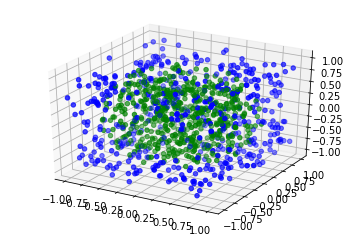

In [35]:
n = 1000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 1, n)
z = np.random.uniform(-1, 1, n)

color = []
treffer = 0
for i in range(0,len(x)):
    color.append( 'g' if inHyperkugel([x[i], y[i], z[i]],1) else 'b')
    if inHyperkugel([x[i], y[i], z[i]],1):
        treffer = treffer + 1
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=color)

A = treffer / n * (2 * 2 * 2)
print("Berechnetes Volumen: " + str(A))
print("Tatsächliche Fläche: " + str(4.0 / 3 * math.pi*1**3))

In [36]:
n = 10000
x1 = np.random.uniform(-1, 1, n)
x2 = np.random.uniform(-1, 1, n)
x3 = np.random.uniform(-1, 1, n)
x4 = np.random.uniform(-1, 1, n)
x5 = np.random.uniform(-1, 1, n)
x6 = np.random.uniform(-1, 1, n)
x7 = np.random.uniform(-1, 1, n)
x8 = np.random.uniform(-1, 1, n)
x9 = np.random.uniform(-1, 1, n)
x10 = np.random.uniform(-1, 1, n)

treffer = 0
color = []
for i in range(0,len(x1)):
    if inHyperkugel([x1[i], x2[i], x3[i], x4[i], x5[i], x6[i], x7[i], x8[i], x9[i], x10[i]],1):
        treffer = treffer + 1

print("Teffer: " + str(treffer) + " von " + str(n))
print("Würfelfläche in 10D: " + str(2**10))
print("Volumen der Kugel: " + str(2**10 * treffer / n))

Teffer: 24 von 10000
Würfelfläche in 10D: 1024
Volumen der Kugel: 2.4576


Aufgabenteil c)
Nun soll mithilfe des Monte-Carlo-Verfahrens die Fläche von Funktionen bestimmt werden.
Funktion 1:

\begin{align}
f(x)=\int_0^2\!sin^2(\frac{1}{x(2-x)}) \, \mathrm{d}x
\end{align}

Auch hier muss wieder eine passende Vergleichsfläche festgelegt werden. Durch die Integralgrenzen lässt sich die x-Achse auf den Bereich 0-2 eingrenzen. Der Wertebereich des Sinus liegt zwischen -1 und 1. Dementsprechend muss der Wertebereich des Quadrates des sinus zwischen 0 und 1 liegen.
Daraus lässt sich ein Rechteck mit den Abmaßen 2x1 als Vergleichsfläche ableiten.

Für die numerische Berechnung muss beachtet werden, dass die Unter- sowie die Obergrenze nicht definiert sind. Dies würde bei der Berechnung zu einem Division-By-Zero-Fehlers führen. Daher werden Werte nahe der Grenze verwendet.

Teffer: 727 von 1000
Vergleichsfläche A: 1.9999999800000001
Errechnete Fläche: 1.45399998546


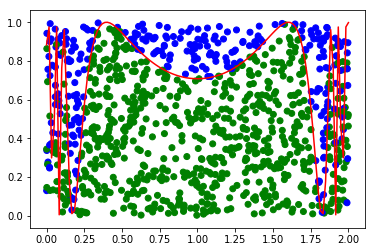

In [37]:
n=1000
upperBoundIntegral = 1.99999999
lowerBoundIntegral = 0.00000001
upperLimit = 1
lowerLimit = 0

def integral(x):
    return math.sin(1.0/(x*(2-x))) * math.sin(1.0/(x*(2-x)))

x = np.random.uniform(lowerBoundIntegral, upperBoundIntegral, n)
y = np.random.uniform(lowerLimit, upperLimit ,n)

color = []
treffer = 0
for i in range(0,len(x)):
    color.append( 'g' if integral(x[i]) >= y[i] else 'b')
    if integral(x[i]) >= y[i]:
        treffer = treffer + 1

plt.scatter(x,y, c=color)
plt.plot(np.linspace(lowerBoundIntegral, upperBoundIntegral,120), [integral (x) for x in np.linspace(lowerBoundIntegral, upperBoundIntegral,120)], c='r')

Aref = (upperBoundIntegral - lowerBoundIntegral) * (upperLimit - lowerLimit)
print("Teffer: " + str(treffer) + " von " + str(n))
print("Vergleichsfläche A: " + str(Aref))
print("Errechnete Fläche: " + str(Aref * treffer / n))

In [38]:
p=treffer/n
varianz = (p - p**2) / (n-1)
standardabw = math.sqrt(varianz / n)
print("Varianz: " +  str(varianz))
print("Standardabweichung: " +  str(standardabw))
print("Standardfehler: " +  str(standardabw / math.sqrt(n)))

Varianz: 0.00019866966966966974
Standardabweichung: 0.00044572375937307823
Standardfehler: 1.4095022868717516e-05


Nach gleichem Prinzip wird nun die Fläche des zweiten Integrals bestimmt:

Funktion 2:

\begin{align}
f(x)=\int_0^1\!\frac{x^{{-\frac{1}{2}}}}{{e^{x}+1}}) \, \mathrm{d}x
\end{align}

Teffer: 200 von 1000
Vergleichsfläche A: 3.999996
Errechnete Fläche: 0.7999992


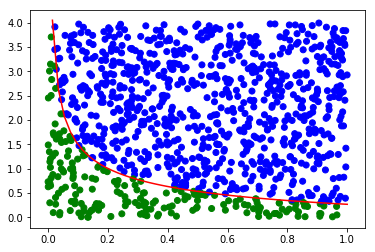

In [40]:
n=1000
upperBoundIntegral = 1
lowerBoundIntegral = 0.000001
upperLimit = 4
lowerLimit = 0

def integral(x):
    return x**(-0.5) / (math.e ** x +1)

x = np.random.uniform(lowerBoundIntegral, upperBoundIntegral, n)
y = np.random.uniform(lowerLimit, upperLimit ,n)

treffer = 0
color = []
for i in range(0,len(x)):
    color.append( 'g' if integral(x[i]) >= y[i] else 'b')
    if integral(x[i]) >= y[i]:
        treffer = treffer + 1

plt.scatter(x,y, c=color)
plt.plot(np.linspace(0.015, upperBoundIntegral,50), [integral (x) for x in np.linspace(0.015, upperBoundIntegral,50)], c='r')

Aref = (upperBoundIntegral - lowerBoundIntegral) * (upperLimit - lowerLimit)
print("Teffer: " + str(treffer) + " von " + str(n))
print("Vergleichsfläche A: " + str(Aref))
print("Errechnete Fläche: " + str(Aref * treffer / n))

In [41]:
p=treffer/n
varianz = (p - p**2) / (n-1)
standardabw = math.sqrt(varianz / n)
print("Varianz: " +  str(varianz))
print("Standardabweichung: " +  str(standardabw))
print("Standardfehler: " +  str(standardabw / math.sqrt(n)))

Varianz: 0.00016016016016016016
Standardabweichung: 0.00040020015012510947
Standardfehler: 1.2655439943366654e-05


## Aufgabe 3: Ising-Modell

In [103]:
L = 20
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)}

def ising(T, nsteps):
    beta = 1.0 / T
    S = [random.choice([1, -1]) for k in range(N)]
    Mag = np.empty(nsteps)
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        delta_E = 2.0 * S[k] * sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E):
            S[k] *= -1
        Mag[step] = sum(S)
    return Mag, S;

1.0082321166992188


Text(0.5,1,'Ising: Hohe Temperatur')

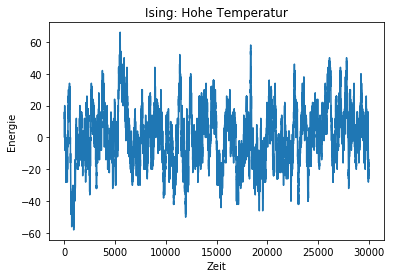

In [104]:
import time
nsteps = 30000
T = 2000

Mag, S = ising(T, nsteps)

plot(Mag)
xlabel('Zeit')
ylabel('Energie')
title('Ising: Hohe Temperatur')

Text(0.5,1,'Ising: Niedrige Temperatur')

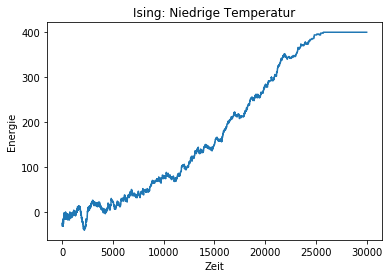

In [83]:
nsteps = 30000
T = 0.1
Mag, S = ising(T, nsteps)
plot(Mag)
xlabel('Zeit')
ylabel('Energie')
title('Ising: Niedrige Temperatur')

Text(0.5,1,'Ising: Temperatur/Energie')

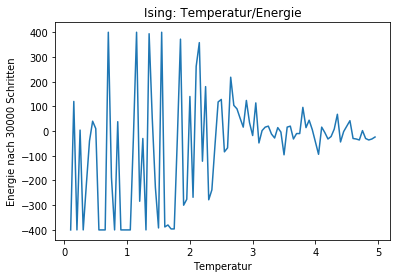

In [106]:
nsteps = 30000
temp_range = arange(0.1, 5, 0.05)
plot (temp_range, [sum(ising(temp, nsteps)[1]) for temp in temp_range])
xlabel('Temperatur')
ylabel('Energie nach ' + str(nsteps) + ' Schritten')
title('Ising: Temperatur/Energie')

## Aufgabe 4: Simulierte Abkühlung und Problem des Handlungsreisenden

In [174]:
def random_neighbour(x, interval, fraction=1):
    amplitude = (max(interval) - min(interval)) * fraction / 10
    delta = (-amplitude/2.) + amplitude * rn.random_sample()
    return max(min(x + delta, interval[1]), interval[0])


def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        return p


def temperature(fraction):
    return max(0.01, min(1, 1 - fraction))

def annealing(start,
              cost_function,
              interval,
              maxsteps=1000):
    state = start
    cost = cost_function(state)
    states, costs = [state], [cost]
    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction)
        new_state = random_neighbour(state, interval, fraction)
        new_cost = cost_function(new_state)
        if acceptance_probability(cost, new_cost, T) > rn.random():
            state, cost = new_state, new_cost
            states.append(state)
            costs.append(cost)
    return state, states, costs

def plotAnneal(f, interval, x_end, states, costs):
    r = arange(interval[0],interval[1],0.01)
    figure(figsize=(15,7))
    subplot(121)
    plot(r, [f(x) for x in r], label='Funktion')
    plot(x_end, f(x_end), '*', markersize=10, label='Minimum')
    plot(states, costs, label='SimAnneal-Verlauf')
    xlabel('X')
    ylabel('Y')
    title('Funktionsverlauf')
    legend()
    
    subplot(122)
    plot(range(len(costs)), costs)
    
    xlabel('Event')
    ylabel('Temp.')
    title('Energieverlauf')

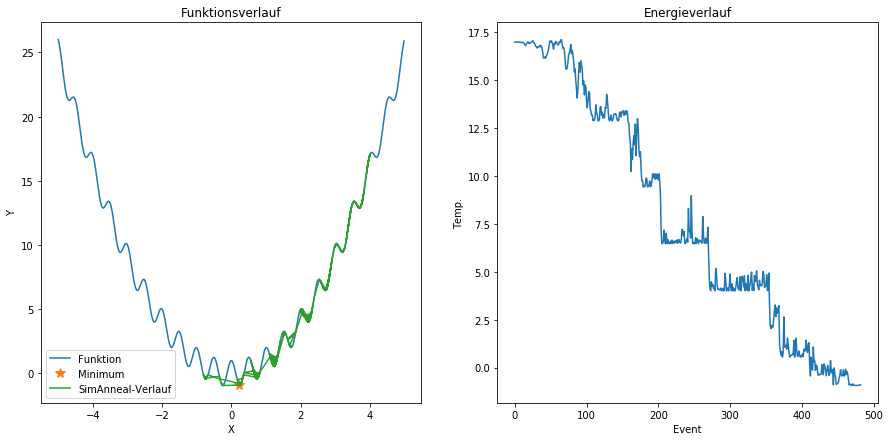

In [175]:
def f1(x, *params):
    return x**2+math.cos(4*math.pi*x)


interval = (-5, 5)
x0 = 4
x_end, states, costs = annealing(x0, f1, interval, 1000)

plotAnneal(f1, interval, x_end, states, costs)

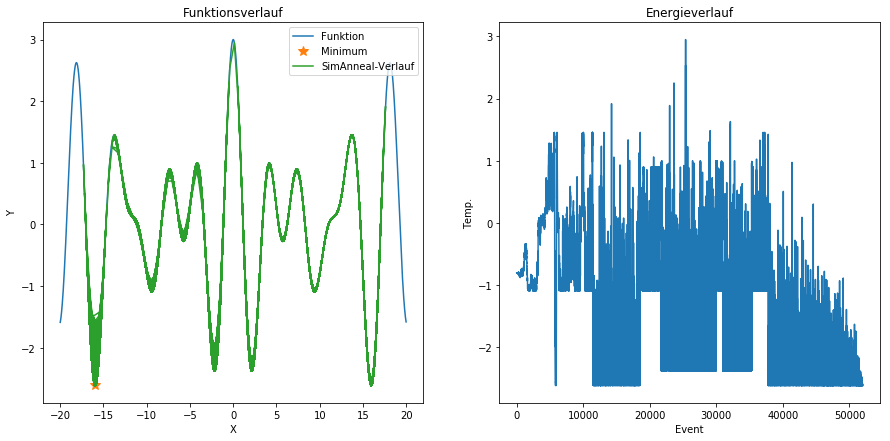

In [176]:
def f2(x, *params):
    return math.cos(x)+math.cos(math.sqrt(2)*x)+math.cos(math.sqrt(3)*x)

interval = (-20, 20)
x0 = 10
x_end, states, costs = annealing(x0, f2, interval, 100000)

plotAnneal(f2, interval, x_end, states, costs)